Savin, Nikitina, Dubenskiy

Romanenko project


In [252]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
# don't forget to upload utils file to the colab session
import warnings

warnings.filterwarnings('ignore')

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"
from sklearn.utils import resample


# # setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
# import seaborn as sns
# sns.set_style("darkgrid")
# pd.plotting.register_matplotlib_converters()
# # Default figure size
# sns.mpl.rc("figure", figsize=(25, 5))
# sns.mpl.rc("font", size=14)

# I. Building Time Series Forecastability Index
Those Time Series that have about the same accuracy level should have the same $\color{red}{Forecastability~Index}$.



<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/Forecastability%20Index.png?raw=true' width = 500pt>

Forecastability index = Function_of_DemandPatterns(Velocity, Variability, Trend, Seasonality, Intermittency) x Horizon

If there is a set of time series, forecastablity index may be presented as table with columns


|FI| No of ts| Demand share|  


Goal of the project: build forecastablity index for particular set

https://www.kaggle.com/t/216ccba5311a44d8a6a8998534523cf7

## Steps to build FI
### 1. Generate segments for each attributes
 - 1.1. Demand Volume (3-groups) - see II.1 and II.2 below
 - 1.2. Demand Variability (volatility coefficient) (3 groups) see II.1 and II. 3 below
 - 1.3. Seasonality (0/1) see https://github.com/aromanenko/ts-segmentation/blob/main/timeseries_segmentation.py
 - 1.4. Trend (0/1) see https://github.com/aromanenko/ts-segmentation/blob/main/timeseries_segmentation.py
 - 1.5. Intermittency (0/1) https://github.com/aromanenko/ts-segmentation/blob/main/timeseries_segmentation.py

### 2. Define benchmark forecastability for eash 5-dim cell from 1
 - 2.1. Use naive forecast to generate forecast for each ts,  see https://github.com/aromanenko/ts-segmentation/blob/main/timeseries_forecasting.py
 - 2.2. Calculate WAPE metic for each 5-dim cell, see https://github.com/aromanenko/ATSF/blob/main/7_Loss%20Functions%20in%20Forecasting.ipynb
 - 2.3. Order all 5-dim cells on WAPE metric (see example below)

### 3. Aggregate 5-dim cells to clusters with similar forecastability
 - use abc-analysis, see II.1 below

# **Загружаем данные**

In [253]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
submission = pd.read_csv("/content/sample_submission.csv")
store_location = pd.read_csv("/content/STORE_LOCATION.csv")

train.head(), test.head()


(   Unnamed: 0  product_rk  store_location_rk period_start_dt  demand  \
 0           0       40369                309      2016-12-19    29.0   
 1           1       40370                309      2016-12-19    64.0   
 2           2       40372                309      2016-12-19    32.0   
 3           3       40373                309      2016-12-19    10.0   
 4           4       46272                309      2016-12-19    15.0   
 
    PROMO1_FLAG  PROMO2_FLAG  PRICE_REGULAR  PRICE_AFTER_DISC  NUM_CONSULTANT  \
 0          NaN          NaN            NaN               NaN             NaN   
 1          NaN          NaN            NaN               NaN             NaN   
 2          NaN          NaN            NaN               NaN             NaN   
 3          NaN          NaN            NaN               NaN             NaN   
 4          NaN          NaN            NaN               NaN             NaN   
 
    AUTORIZATION_FLAG  
 0                NaN  
 1                NaN  


# Общий обзор данных

In [254]:
print("train.csv - первые 5 строк:")
display(train.head())

print("test.csv - первые 5 строк:")
display(test.head())

print("Информация о train данных:")
train_info = pd.DataFrame({
    'Тип данных': train.dtypes,
    'Уникальных значений': train.nunique(),
    'Пропущенных значений': train.isnull().sum(),
    '% Пропусков': (train.isnull().sum() / len(train) * 100).round(2)
})
display(train_info)

train.csv - первые 5 строк:


,Unnamed: 0,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
0,0,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN,NaN


test.csv - первые 5 строк:


,id,product_rk,store_location_rk,period_start_dt,demand
0,908,40369,317,02.12.2019,NaN
1,909,40370,317,02.12.2019,NaN
2,910,40372,317,02.12.2019,NaN
3,911,40373,317,02.12.2019,NaN
4,912,46272,317,02.12.2019,NaN


Информация о train данных:


,Тип данных,Уникальных значений,Пропущенных значений,% Пропусков
Unnamed: 0,int64,35344,0,0.00
product_rk,int64,6,0,0.00
store_location_rk,int64,41,0,0.00
period_start_dt,object,159,0,0.00
demand,float64,1806,1200,3.40
PROMO1_FLAG,float64,3,185,0.52
PROMO2_FLAG,float64,1,185,0.52
PRICE_REGULAR,float64,229,1127,3.19
PRICE_AFTER_DISC,float64,1036,1132,3.20
NUM_CONSULTANT,float64,1,185,0.52


# Статистический анализ

In [255]:
print("\n" + "=" * 60)
print("2. СТАТИСТИЧЕСКИЙ АНАЛИЗ (describe)")
print("=" * 60)

print("Числовые столбцы (describe):")
numeric_cols = train.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    display(train[numeric_cols].describe().T.style.background_gradient(cmap='Blues', subset=['mean', '50%']))
else:
    print("Нет числовых столбцов в train данных")

print("Категориальные столбцы (describe):")
categorical_cols = train.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    for col in categorical_cols:
        print(f"\n--- {col} ---")
        print(f"Уникальных значений: {train[col].nunique()}")
        print(f"Топ-5 частых значений:")
        display(train[col].value_counts().head())
else:
    print("Нет категориальных столбцов в train данных")


2. СТАТИСТИЧЕСКИЙ АНАЛИЗ (describe)
Числовые столбцы (describe):


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,35344.000000,17766.554012,10258.040738,0.000000,8881.750000,17770.500000,26647.250000,35541.000000
product_rk,35344.000000,49253.732232,19145.064867,40369.000000,40370.000000,40372.000000,46272.000000,96212.000000
store_location_rk,35344.000000,844.240154,333.229160,309.000000,535.000000,862.000000,1173.000000,1380.000000
demand,34144.000000,12.245636,32.604642,0.000000,2.000000,6.000000,12.000000,1160.000000
PROMO1_FLAG,35159.000000,0.206434,0.433393,0.000000,0.000000,0.000000,0.000000,2.000000
PROMO2_FLAG,35159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PRICE_REGULAR,34217.000000,1167.679357,1046.828551,49.000000,284.290000,1000.000000,2000.000000,3000.000000
PRICE_AFTER_DISC,34212.000000,1155.778351,1057.912830,8.647059,199.000000,1000.000000,2000.000000,3000.000000
NUM_CONSULTANT,35159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AUTORIZATION_FLAG,35159.000000,0.907677,0.289486,0.000000,1.000000,1.000000,1.000000,1.000000


Категориальные столбцы (describe):

--- period_start_dt ---
Уникальных значений: 159
Топ-5 частых значений:


,count
period_start_dt,
2019-09-23,240
2019-09-30,240
2019-10-07,240
2019-10-14,240
2019-10-21,240


# Визуализация

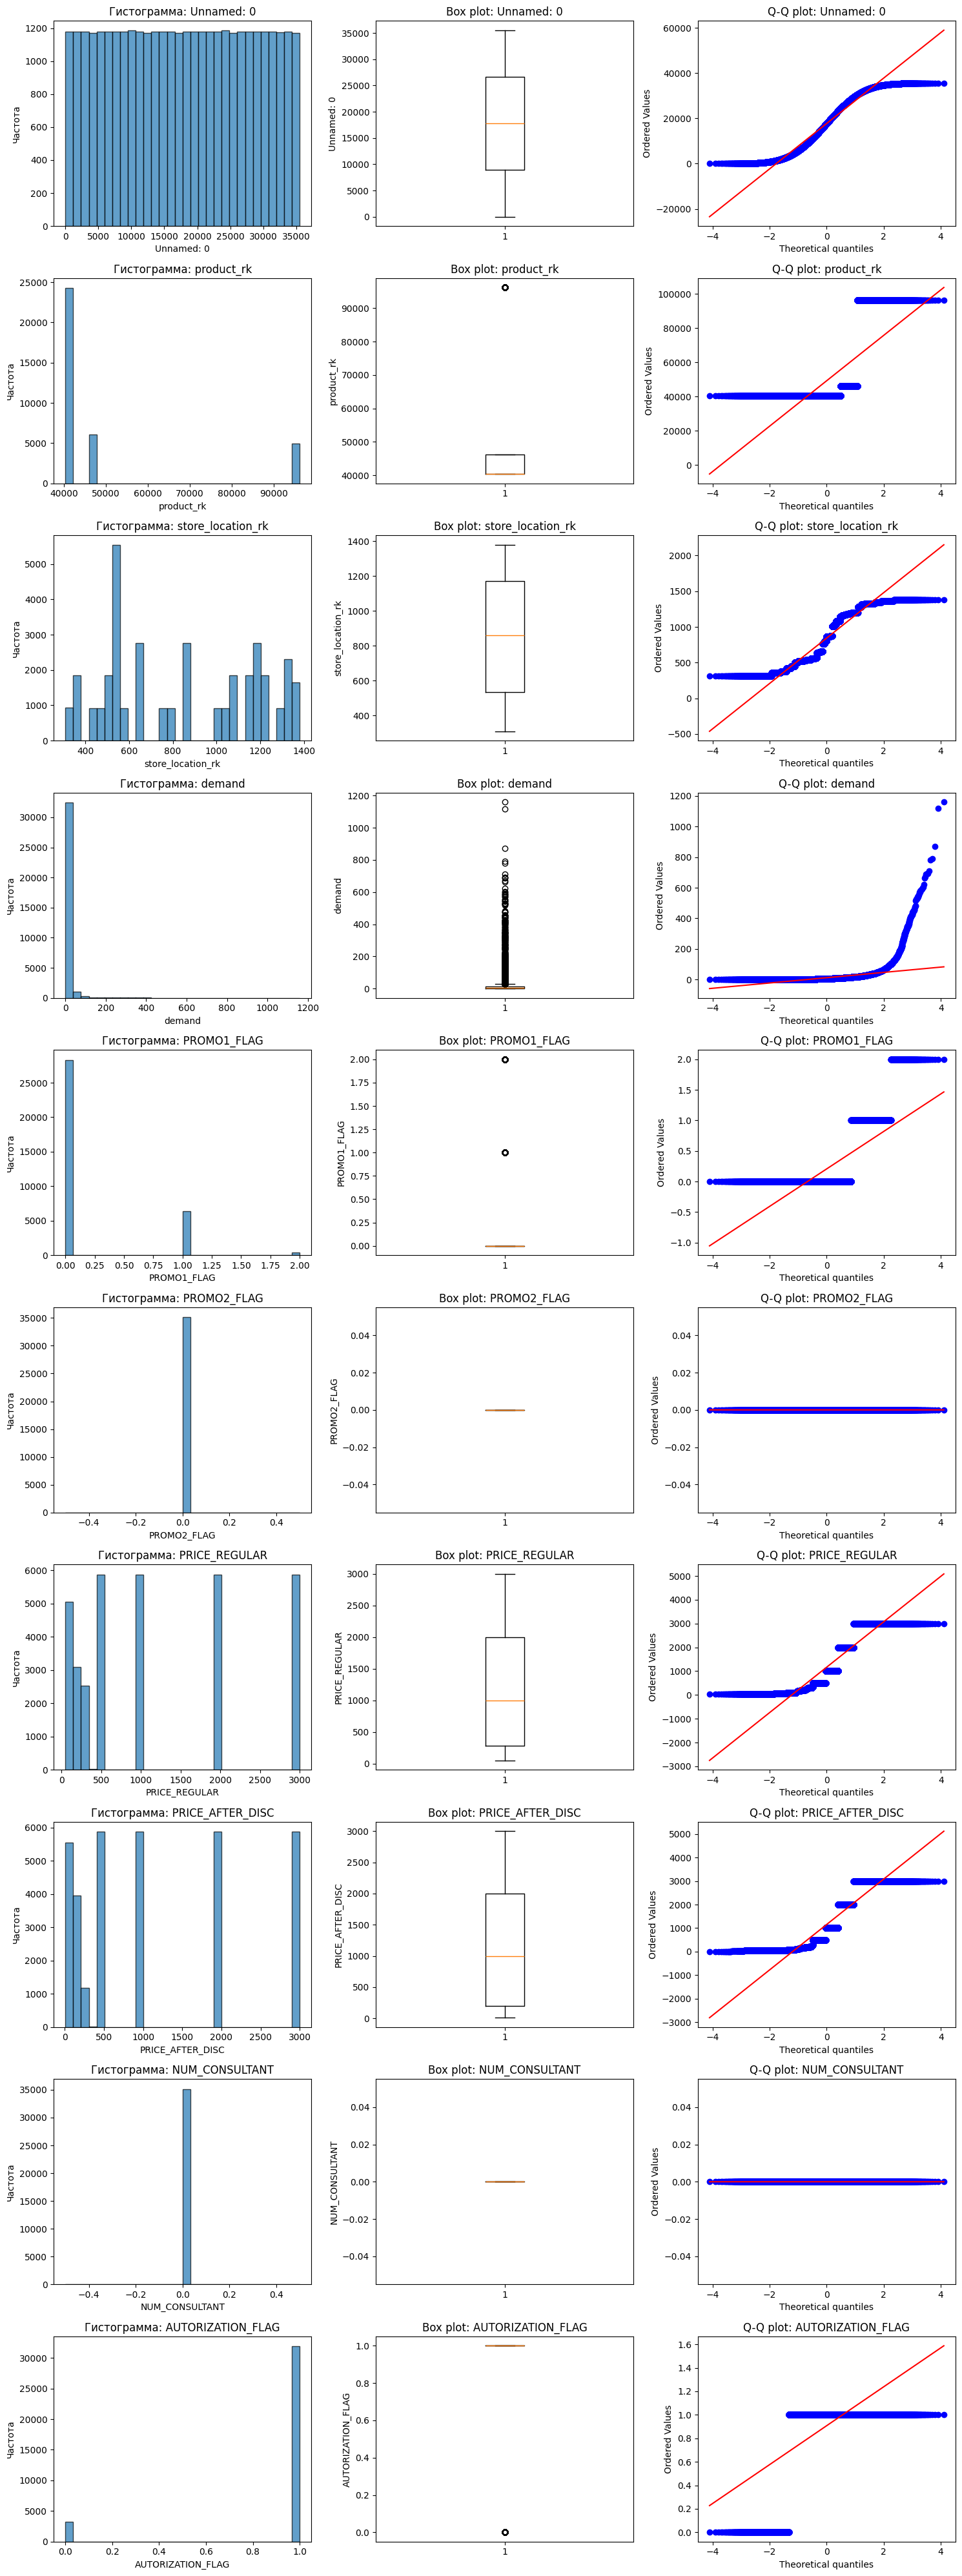

In [256]:
if len(numeric_cols) > 0:
    fig, axes = plt.subplots(len(numeric_cols), 3, figsize=(15, 4*len(numeric_cols)))

    if len(numeric_cols) == 1:
        axes = np.array([axes]).T

    for i, col in enumerate(numeric_cols):
        axes[i, 0].hist(train[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[i, 0].set_title(f'Гистограмма: {col}')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Частота')
        axes[i, 1].boxplot(train[col].dropna())
        axes[i, 1].set_title(f'Box plot: {col}')
        axes[i, 1].set_ylabel(col)
        from scipy import stats
        stats.probplot(train[col].dropna(), dist="norm", plot=axes[i, 2])
        axes[i, 2].set_title(f'Q-Q plot: {col}')

    plt.tight_layout()
    plt.show()

# Анализ Пропущеных значений

,Пропуски в train,% от train,Пропуски в test,% от test
AUTORIZATION_FLAG,185.0,0.52,NaN,NaN
NUM_CONSULTANT,185.0,0.52,NaN,NaN
PRICE_AFTER_DISC,1132.0,3.20,NaN,NaN
PRICE_REGULAR,1127.0,3.19,NaN,NaN
PROMO1_FLAG,185.0,0.52,NaN,NaN
PROMO2_FLAG,185.0,0.52,NaN,NaN
demand,1200.0,3.40,1404.0,100.0


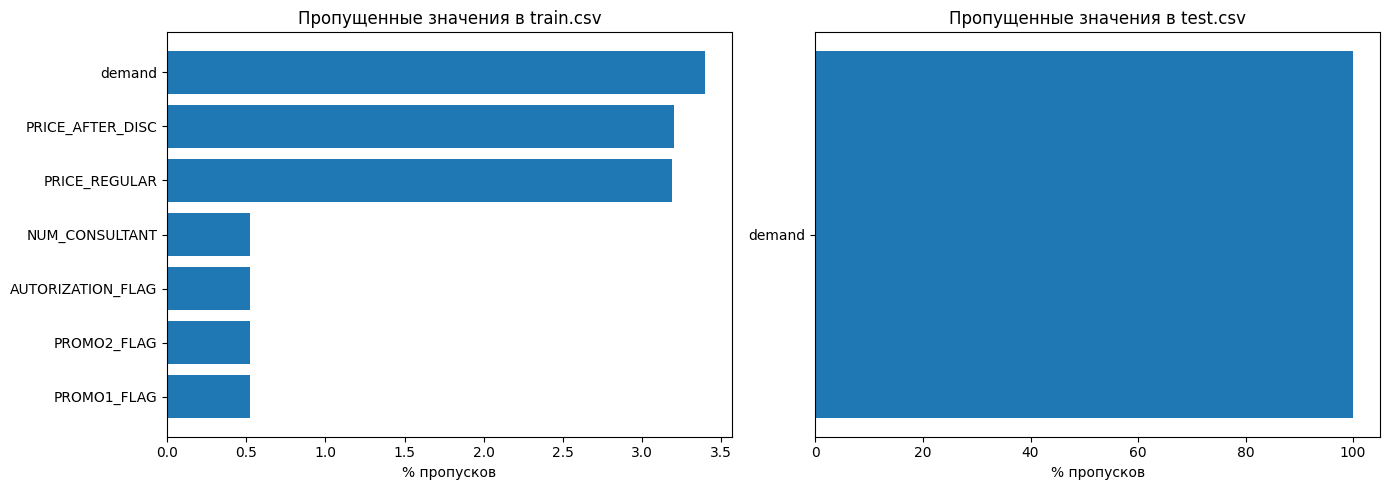

In [257]:
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()

missing_summary = pd.DataFrame({
    'Пропуски в train': missing_train,
    '% от train': (missing_train / len(train) * 100).round(2),
    'Пропуски в test': missing_test,
    '% от test': (missing_test / len(test) * 100).round(2)
})

display(missing_summary[missing_summary['Пропуски в train'] > 0])

if missing_train.sum() > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    missing_train_percentage = (missing_train[missing_train > 0] / len(train) * 100).sort_values(ascending=True)
    axes[0].barh(range(len(missing_train_percentage)), missing_train_percentage.values)
    axes[0].set_yticks(range(len(missing_train_percentage)))
    axes[0].set_yticklabels(missing_train_percentage.index)
    axes[0].set_xlabel('% пропусков')
    axes[0].set_title('Пропущенные значения в train.csv')

    missing_test_percentage = (missing_test[missing_test > 0] / len(test) * 100).sort_values(ascending=True)
    axes[1].barh(range(len(missing_test_percentage)), missing_test_percentage.values)
    axes[1].set_yticks(range(len(missing_test_percentage)))
    axes[1].set_yticklabels(missing_test_percentage.index)
    axes[1].set_xlabel('% пропусков')
    axes[1].set_title('Пропущенные значения в test.csv')

    plt.tight_layout()
    plt.show()

# Сравнение Тест и Трейн

In [258]:
print("Столбцы train:", list(train.columns))
print("Столбцы test:", list(test.columns))

common_cols = set(train.columns) & set(test.columns)
print(f"\nОбщие столбцы: {len(common_cols)}")
print(f"Уникальные в train: {set(train.columns) - set(test.columns)}")
print(f"Уникальные в test: {set(test.columns) - set(train.columns)}")

Столбцы train: ['Unnamed: 0', 'product_rk', 'store_location_rk', 'period_start_dt', 'demand', 'PROMO1_FLAG', 'PROMO2_FLAG', 'PRICE_REGULAR', 'PRICE_AFTER_DISC', 'NUM_CONSULTANT', 'AUTORIZATION_FLAG']
Столбцы test: ['id', 'product_rk', 'store_location_rk', 'period_start_dt', 'demand']

Общие столбцы: 4
Уникальные в train: {'PROMO1_FLAG', 'Unnamed: 0', 'NUM_CONSULTANT', 'AUTORIZATION_FLAG', 'PROMO2_FLAG', 'PRICE_AFTER_DISC', 'PRICE_REGULAR'}
Уникальные в test: {'id'}


# **Глобальная фильтрация по времени работы магазинов**

In [259]:
# Загружаем справочник магазинов
store_loc = pd.read_csv('STORE_LOCATION.csv', sep=';')

# Приводим даты к datetime
def parse_store_date(date_str):
    try:
        return pd.to_datetime(date_str.split(':')[0], format='%d%b%Y')
    except:
        return pd.NaT

store_loc['open_dt'] = store_loc['STORE_OPEN_DTTM'].apply(parse_store_date)
store_loc['close_dt'] = store_loc['STORE_CLOSURE_DTTM'].apply(parse_store_date)

if 'ts_retail' not in globals():
    ts_retail = pd.read_csv('train.csv')
    ts_retail['period_start_dt'] = pd.to_datetime(ts_retail['period_start_dt'])

# Нам нужны только даты открытия/закрытия
ts_retail = ts_retail.merge(store_loc[['STORE_LOCATION_RK', 'open_dt', 'close_dt']],
                            left_on='store_location_rk',
                            right_on='STORE_LOCATION_RK',
                            how='left')

# Оставляем продажи только когда магазин был открыт
rows_before = len(ts_retail)
ts_retail = ts_retail[
    (ts_retail['period_start_dt'] >= ts_retail['open_dt']) &
    (ts_retail['period_start_dt'] <= ts_retail['close_dt'])
]
rows_after = len(ts_retail)

print(f"Удалено {rows_before - rows_after} строк, когда магазины были закрыты.")

# Убираем лишние колонки
ts_retail.drop(columns=['STORE_LOCATION_RK', 'open_dt', 'close_dt'], inplace=True)

Удалено 35344 строк, когда магазины были закрыты.


## 1. Generate Segments for each Attributes

### 1.1. Demand Volume segmentation

In [260]:
# --- 1) Загружаем спрос (основной датасет) ---
ts_retail = pd.read_csv('train.csv')

# на всякий случай уберём мусорные колонки
ts_retail = ts_retail.drop(columns=['Unnamed: 0'], errors='ignore')

for col in ['period_start_dt', 'date', 'Date', 'ds']:
    if col in ts_retail.columns:
        ts_retail[col] = pd.to_datetime(ts_retail[col], errors='coerce')
        break


# --- Идентификаторы "серий"
ts_id_columns = ['store_location_rk', 'product_rk']

ts_retail.head()


,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
0,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN,NaN
1,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN,NaN
2,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN,NaN
3,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN,NaN
4,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN,NaN


In [261]:
def abc_analysis(values, return_idx=True, a_share=0.80, b_share=0.95,
                 plot=True, title="ABC analysis"):
    """
    ABC-анализ по вкладу в суммарный объем.
    Возвращает индексы элементов A/B/C и строит график
    """

    x = np.asarray(values, dtype=float)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

    n = len(x)
    if n == 0:
        res = {'A': np.array([], dtype=int), 'B': np.array([], dtype=int), 'C': np.array([], dtype=int)}
        res.update({'Aind': res['A'], 'Bind': res['B'], 'Cind': res['C']})
        return res

    order = np.argsort(-x)            # по убыванию
    sorted_x = x[order]
    total = sorted_x.sum()

    if total <= 0:
        res = {'A': np.array([], dtype=int), 'B': np.array([], dtype=int), 'C': np.arange(n, dtype=int)}
        res.update({'Aind': res['A'], 'Bind': res['B'], 'Cind': res['C']})
        return res

    cum_share = np.cumsum(sorted_x) / total
    frac_data = np.arange(1, n + 1) / n

    # границы по доле вклада (80% и 95% по умолчанию)
    i_ab = int(np.searchsorted(cum_share, a_share, side='left'))   # индекс границы A|B
    i_bc = int(np.searchsorted(cum_share, b_share, side='left'))   # индекс границы B|C

    # маски сегментов
    a_mask = np.zeros(n, dtype=bool); a_mask[:i_ab + 1] = True
    b_mask = np.zeros(n, dtype=bool); b_mask[i_ab + 1:i_bc + 1] = True
    c_mask = np.zeros(n, dtype=bool); c_mask[i_bc + 1:] = True

    A = order[a_mask]
    B = order[b_mask]
    C = order[c_mask]

    #ГРАФИК
    if plot:
        xA = frac_data[i_ab] if i_ab >= 0 and i_ab < n else 0.0
        yA = cum_share[i_ab] if i_ab >= 0 and i_ab < n else 0.0
        xB = frac_data[i_bc] if i_bc >= 0 and i_bc < n else 0.0
        yB = cum_share[i_bc] if i_bc >= 0 and i_bc < n else 0.0

        plt.figure(figsize=(10, 6))
        plt.title(title, fontsize=22)

        # data (зелёная)
        plt.plot(frac_data, cum_share, color='green', linewidth=2, label='data')

        # identity (синяя диагональ)
        plt.plot([0, 1], [0, 1], color='blue', linestyle='--', linewidth=2, label='identity')

        # uniform (серая пунктирная)
        plt.plot([0, 1], [1, 0], color='gray', linestyle='--', linewidth=2, label='uniform')

        # красные границы
        plt.axvline(xA, color='red', linewidth=2)
        plt.axhline(yA, color='red', linewidth=2)
        plt.axvline(xB, color='red', linewidth=2)
        plt.axhline(yB, color='red', linewidth=2)
        plt.scatter([xA, xB], [yA, yB], color='red', s=60, zorder=5)

        # подписи областей
        plt.text(max(0.06, xA * 0.35), max(0.15, yA * 0.45), "A", color='red', fontsize=26)
        plt.text(min(0.65, (xA + xB) / 2), 0.12, "B", color='red', fontsize=26)
        plt.text(min(0.85, xB + (1 - xB) * 0.35), 0.90, "C", color='red', fontsize=26)

        # подписи границ
        plt.text(xA * 0.7, min(0.95, yA + 0.08), "A|B", color='red', fontsize=16)
        plt.text(xB * 0.85, min(0.95, yB + 0.05), "B|C", color='red', fontsize=16)

        # n-подписи
        plt.text(max(0.03, xA * 0.25), max(0.15, yA * 0.35), f"n={len(A)}", color='black')
        plt.text(min(0.75, (xA + xB) / 2), 0.45, f"n={len(B)}", color='black')

        plt.xlabel("fraction of data")
        plt.ylabel("fraction of sum of largest data")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.35)
        plt.legend()
        plt.show()

    res = {'A': A, 'B': B, 'C': C}
    # алиасы
    res.update({'Aind': A, 'Bind': B, 'Cind': C})
    return res


In [262]:
ts_id_columns = ['store_location_rk', 'product_rk']


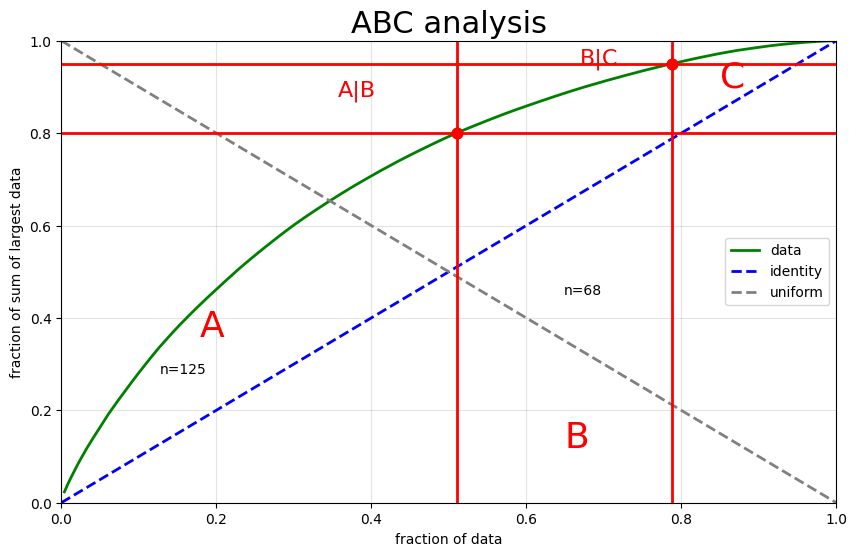

,store_location_rk,product_rk,demand_volume,volume_group
0,309,40369,206.0,C
1,309,40370,315.0,C
2,309,40372,150.0,C
3,309,40373,113.0,C
4,309,46272,51.0,C


In [263]:
# 1) объем спроса по паре store-product
ts_volume_values = ts_retail.groupby(ts_id_columns)['demand'].sum()

# 2) ABC-анализ (индексы A/B/C)
ts_volume_abc = abc_analysis(ts_volume_values.fillna(0).values, True)

# 3) таблица сегментов + метки
volume = ts_volume_values.reset_index(name='demand_volume')
volume['volume_group'] = 'C'
volume.loc[ts_volume_abc['A'], 'volume_group'] = 'A'
volume.loc[ts_volume_abc['B'], 'volume_group'] = 'B'

volume.head()


In [264]:
ts_retail = ts_retail.merge(
    volume[ts_id_columns + ['demand_volume', 'volume_group']],
    on=ts_id_columns,
    how='left'
)

ts_retail.head()


,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,demand_volume,volume_group
0,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,C
1,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN,NaN,315.0,C
2,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN,NaN,150.0,C
3,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN,NaN,113.0,C
4,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN,NaN,51.0,C


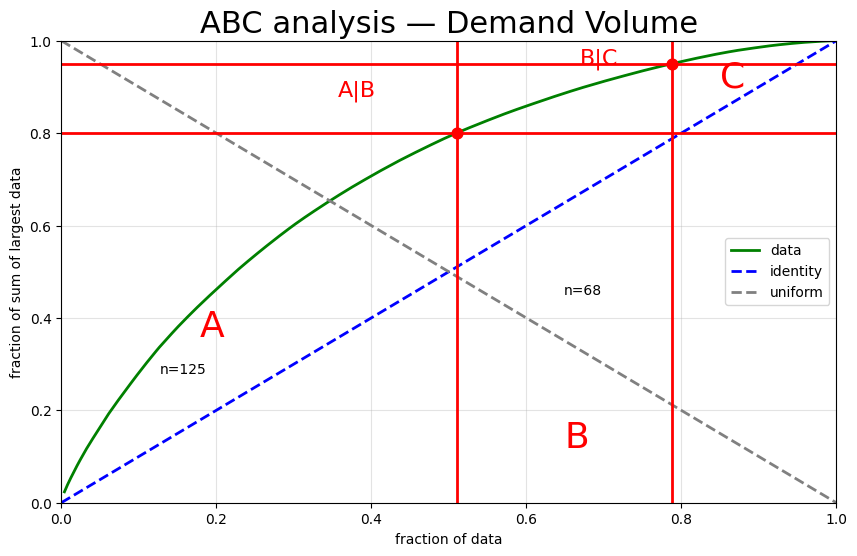

,store_location_rk,product_rk,demand_volume,volume_group
0,309,40369,206.0,C
1,309,40370,315.0,C
2,309,40372,150.0,C
3,309,40373,113.0,C
4,309,46272,51.0,C


volume_group
A    125
B     68
C     52
Name: count, dtype: int64


In [265]:
# 1.1

ts_id_columns = ['store_location_rk', 'product_rk']

# считаем объем спроса по каждой паре товар–магазин
volume = (
    ts_retail
    .groupby(ts_id_columns)['demand']
    .sum()
    .reset_index(name='demand_volume')
)

# ABC-анализ + график (рисует abc_analysis)
abc_vol = abc_analysis(
    volume['demand_volume'].fillna(0).values,
    True,
    plot=True,
    title="ABC analysis — Demand Volume"
)

# присваиваем группы A/B/C
volume['volume_group'] = 'C'
volume.loc[abc_vol['A'], 'volume_group'] = 'A'
volume.loc[abc_vol['B'], 'volume_group'] = 'B'

# присоединяем группы к исходным данным
# --- SAFE MERGE: 1.1 Demand Volume ---

# 1) Удаляем старые версии колонок (если они есть)
ts_retail = ts_retail.drop(
    columns=['demand_volume', 'volume_group'],
    errors='ignore'
)

# 2) Присоединяем ТОЛЬКО нужные колонки
ts_retail = ts_retail.merge(
    volume[['store_location_rk', 'product_rk',
               'demand_volume', 'volume_group']],
    on=['store_location_rk', 'product_rk'],
    how='left'
)

display(volume.head())
print(volume['volume_group'].value_counts())


In [266]:

ts_retail.head()

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,demand_volume,volume_group
0,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,C
1,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN,NaN,315.0,C
2,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN,NaN,150.0,C
3,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN,NaN,113.0,C
4,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN,NaN,51.0,C


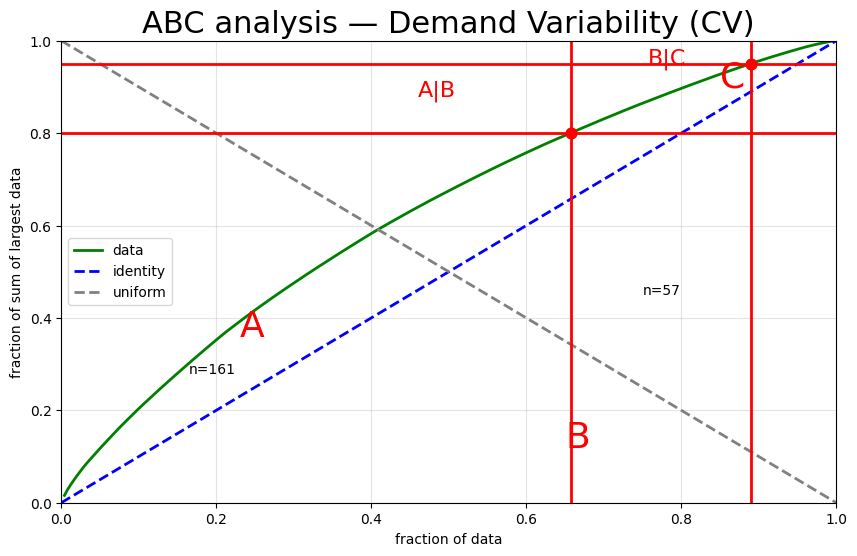

,store_location_rk,product_rk,demand_cv,variability_group
0,309,40369,0.613535,C
1,309,40370,0.512342,C
2,309,40372,0.537649,C
3,309,40373,0.558715,C
4,309,46272,0.254147,C


variability_group
A    161
B     57
C     27
Name: count, dtype: int64


In [267]:
# 1.2

g = ts_retail.groupby(ts_id_columns)['demand']

mean_d = g.mean()
std_d  = g.std(ddof=0)

ts_cv_values = (std_d / mean_d.replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)

# ABC-анализ + график
abc_var = abc_analysis(
    ts_cv_values.values,
    True,
    plot=True,
    title="ABC analysis — Demand Variability (CV)"
)

demand_var = ts_cv_values.reset_index(name='demand_cv')

# присваиваем группы A/B/C
demand_var['variability_group'] = 'C'
demand_var.loc[abc_var['A'], 'variability_group'] = 'A'
demand_var.loc[abc_var['B'], 'variability_group'] = 'B'


# присоединяем к исходным данным
ts_retail = ts_retail.merge(
    demand_var[ts_id_columns + ['demand_cv', 'variability_group']],
    on=ts_id_columns,
    how='left'
)

display(demand_var.head())
print(demand_var['variability_group'].value_counts())


In [268]:


ts_retail.head()


,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,demand_volume,volume_group,demand_cv,variability_group
0,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,C,0.613535,C
1,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN,NaN,315.0,C,0.512342,C
2,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN,NaN,150.0,C,0.537649,C
3,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN,NaN,113.0,C,0.558715,C
4,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN,NaN,51.0,C,0.254147,C


# **1.3. Признак Seasonality (0/1)**


Признак Seasonality определяет, содержит ли временной ряд статистически значимую сезонную компоненту.
Поскольку в исходном датасете отсутствуют календарные признаки (например, день недели),
сезонность определяется только по самой динамике спроса.

Результат:

* 1 — сезонность присутствует

* 0 — сезонности нет или недостаточно данных

1) Получение временного ряда по SKU × Store

    Извлекает временной ряд спроса для конкретного товара и магазина.
    
    Зачем нужна функция:
    - Оригинальный датафрейм содержит данные для всех товаров и магазинов
    - Нам нужно изолировать данные для конкретной пары (product_rk, store_rk)
    - Функция фильтрует, сортирует по дате и преобразует в временной ряд
    
    Параметры:
    df : pd.DataFrame
        Исходный датафрейм с колонками product_rk, store_location_rk, period_start_dt, demand
    product_rk : int
        Идентификатор товара (SKU)
    store_rk : int
        Идентификатор магазина
    
    Возвращает:
    pd.Series
        Временной ряд спроса с датами в качестве индекса

In [269]:
def get_ts(df: pd.DataFrame, product_rk: int, store_rk: int) -> pd.Series:
    mask = (df['product_rk'] == product_rk) & (df['store_location_rk'] == store_rk)
    filtered_df = df[mask]
    filtered_df = filtered_df.sort_values('period_start_dt')
    ts = filtered_df.set_index('period_start_dt')['demand'].astype(float)

    return ts

2) Оценка сезонного периода (lag)

    Определяет наиболее вероятный сезонный период (лаг) временного ряда.
    
    Зачем нужна функция:
    - Сезонность означает повторяющиеся паттерны с фиксированным интервалом
    - Нужно найти этот интервал (например, неделя, месяц, год)
    - Используется автокорреляционная функция (ACF) для поиска периодов
    
    Алгоритм:
    1. Вычисляем автокорреляцию ряда
    2. Находим пики в автокорреляционной функции
    3. Выбираем лаг с максимальной автокорреляцией как сезонный период
    
    Параметры:
    ts : np.ndarray
        Временной ряд (массив значений спроса)
    
    Возвращает:
    int
        Предполагаемый сезонный период (лаг).
        Возвращает 1 если данных недостаточно или сезонность не найдена.
    """

In [270]:
def find_seasonality_period(ts: np.ndarray) -> int:


    ts_clean = ts[~np.isnan(ts)].astype(float)
    if len(ts_clean) < 3:
        return 1
    ts_normalized = ts_clean - ts_clean.mean()
    acf_full = np.correlate(ts_normalized, ts_normalized, 'full')
    acf = acf_full[-len(ts_normalized):]
    first_diff = np.diff(acf)
    second_diff = np.diff(np.sign(first_diff))
    peaks = (second_diff < 0).nonzero()[0] + 1
    if len(peaks) == 0:
        return 1
    best_peak_idx = np.argmax(acf[peaks])
    seasonal_period = int(peaks[best_peak_idx])

    return seasonal_period

3) Тест на сезонность

Сезонность считается присутствующей, если:

* длина ряда значительно превышает сезонный лаг

* автокорреляция на сезонном лаге достаточно высокая

    Проверяет, имеет ли временной ряд статистически значимую сезонную компоненту.
    
    Зачем нужна функция:
    - Определяет, нужно ли учитывать сезонность при прогнозировании
    - Помогает выбрать правильную модель (с сезонностью или без)
    
    Критерии сезонности:
    1. Ряд должен быть достаточно длинным (min_series_length)
    2. Длина ряда должна значительно превышать сезонный период (min_excess_length)
    3. Автокорреляция на сезонном лаге должна быть высокой (correlation_threshold)
    
    Параметры:
    ts : np.ndarray
        Временной ряд
    min_series_length : int
        Минимальная длина ряда для анализа (по умолчанию 5)
    min_excess_length : int
        На сколько должна превышать длина ряда сезонный период (по умолчанию 10)
    correlation_threshold : float
        Порог для нормированной автокорреляции (по умолчанию 0.25)
    
    Возвращает:
    int
        1 - сезонность присутствует
        0 - сезонности нет или недостаточно данных

In [271]:
def has_seasonality(ts: np.ndarray,
                    min_series_length: int = 5,
                    min_excess_length: int = 10,
                    correlation_threshold: float = 0.25) -> int:
    ts_clean = ts[~np.isnan(ts)].astype(float)
    if len(ts_clean) < min_series_length:
        print(f"  Слишком короткий ряд ({len(ts_clean)} < {min_series_length}) → сезонность 0")
        return 0
    seasonal_period = find_seasonality_period(ts_clean)
    if len(ts_clean) <= seasonal_period + min_excess_length:
        print(f"  Ряд слишком короткий для периода {seasonal_period} "
              f"({len(ts_clean)} ≤ {seasonal_period} + {min_excess_length}) → сезонность 0")
        return 0
    ts_normalized = ts_clean - ts_clean.mean()
    acf_full = np.correlate(ts_normalized, ts_normalized, 'full')
    acf = acf_full[-len(ts_normalized):]
    acf_norm = acf / acf[0]
    acf_at_seasonal_lag = acf_norm[seasonal_period]
    has_seasonality_flag = int(acf_at_seasonal_lag > correlation_threshold)
    print(f"  Длина ряда: {len(ts_clean)}, Сезонный период: {seasonal_period}, "
          f"ACF(период): {acf_at_seasonal_lag:.3f}, "
          f"Порог: {correlation_threshold}, Сезонность: {has_seasonality_flag}")

    return has_seasonality_flag

4) Создание датафрейма с флагами сезонности для всех SKU × Store

    Создает датафрейм с флагами сезонности для всех уникальных пар SKU × Store.
    
    Зачем нужна функция:
    - Оригинальный train_df не содержит признака сезонности
    - Нужно вычислить сезонность для каждой комбинации товар-магазин
    - Результат можно использовать как признак в модели или для анализа
    
    Параметры:
    train_df : pd.DataFrame
        Обучающий датафрейм
    
    Возвращает:
    pd.DataFrame
        Датафрейм с колонками: product_rk, store_location_rk, has_seasonality

In [272]:
def create_seasonality_dataframe(train_df: pd.DataFrame) -> pd.DataFrame:
    unique_pairs = train_df[['product_rk', 'store_location_rk']].drop_duplicates()
    print(f"Всего уникальных пар: {len(unique_pairs)}")
    seasonality_results = []
    for idx, (product_rk, store_rk) in enumerate(unique_pairs.itertuples(index=False), 1):
        ts_series = get_ts(train_df, product_rk, store_rk)
        ts_array = ts_series.values
        seasonal_flag = has_seasonality(ts_array)
        seasonality_results.append({
            'product_rk': product_rk,
            'store_location_rk': store_rk,
            'has_seasonality': seasonal_flag
        })

        if idx % 100 == 0:
            print(f"Обработано {idx}/{len(unique_pairs)} пар")

    seasonality_df = pd.DataFrame(seasonality_results)

    seasonal_count = seasonality_df['has_seasonality'].sum()
    print(f"\nСтатистика сезонности:")
    print(f"  Всего пар: {len(seasonality_df)}")
    print(f"  Сезонные (has_seasonality=1): {seasonal_count} ({seasonal_count/len(seasonality_df)*100:.1f}%)")
    print(f"  Несезонные (has_seasonality=0): {len(seasonality_df) - seasonal_count} ({(len(seasonality_df) - seasonal_count)/len(seasonality_df)*100:.1f}%)")

    return seasonality_df

тест

In [273]:
if __name__ == "__main__":
    try:
        print(f"Размер train: {train.shape}")
        test_product_rk = 40369
        test_store_rk = 309

        print(f"\nТестируем для product_rk={test_product_rk}, store_rk={test_store_rk}")
        print("\n1. Извлечение временного ряда...")
        test_ts = get_ts(train, test_product_rk, test_store_rk)
        print(f"   Длина ряда: {len(test_ts)}")
        print(f"   Диапазон дат: {test_ts.index[0]} до {test_ts.index[-1]}")
        print(f"   Первые значения:\n{test_ts.head()}")
        print("\n2. Поиск сезонного периода...")
        ts_array = test_ts.values
        seasonal_period = find_seasonality_period(ts_array)
        print(f"   Предполагаемый сезонный период: {seasonal_period}")
        print("\n3. Проверка наличия сезонности...")
        seasonality_flag = has_seasonality(ts_array)
        print(f"   Флаг сезонности: {seasonality_flag}")
        print("\n4. Создание полного датафрейма сезонности...")

    except NameError:
        print("ОШИБКА: Переменная 'train' не определена.")

Размер train: (35344, 11)

Тестируем для product_rk=40369, store_rk=309

1. Извлечение временного ряда...
   Длина ряда: 3
   Диапазон дат: 2016-12-19 до 2017-01-02
   Первые значения:
period_start_dt
2016-12-19     29.0
2016-12-26    127.0
2017-01-02     50.0
Name: demand, dtype: float64

2. Поиск сезонного периода...
   Предполагаемый сезонный период: 1

3. Проверка наличия сезонности...
  Слишком короткий ряд (3 < 5) → сезонность 0
   Флаг сезонности: 0

4. Создание полного датафрейма сезонности...


# **1.4. Trend segments (0/1)**

Признак Trend показывает, имеет ли временной ряд статистически значимую направленную динамику (рост/падение).
Тренд определяется с помощью линейной регрессии: если наклон значим по

p-value ≤ 0.05 → ряд трендовый.

<font color="red">
  
  -  хорошая идея, только нужно больше комментариев в коде
  
  -  нужна разметка ВСЕХ исходных данных по этому критерию
  
  -  функцию вынести в отдельный py-файл в code
</font>

In [274]:
from scipy.stats import linregress
import numpy as np

def get_trend_flag(ts):
    ts = np.array(ts, dtype=float)
    ts = ts[~np.isnan(ts)]

    if len(ts) < 5:
        return 0
    x = np.arange(len(ts))
    res = linregress(x, ts)

    return int(res.pvalue <= 0.05)

In [275]:
ts = get_ts(train, product_rk=40369, store_rk=309)
get_trend_flag(ts)


0

# **1.5. Intermittency (0/1)**




Признак Intermittency отражает «рваность» ряда — редкое появление спроса.
Ряд считается интермиттирующим, если

медианная длина непрерывных ненулевых участков < 2.



In [276]:
from scipy.stats import chi2_contingency

In [277]:
def is_intermittent(ts):
    ts = np.array(ts, dtype=float)
    ts = ts[~np.isnan(ts)]

    if len(ts) < 3:
        return 0

    intervals = []
    cur = 0
    for val in ts:
        if val == 0:
            if cur > 0:
                intervals.append(cur)
            cur = 0
        else:
            cur += 1
    if cur > 0:
        intervals.append(cur)

    if len(intervals) == 0:
        return 0

    return int(np.median(intervals) < 2)

НОВАЯ ФУНКЦИЯ С CONTINGENCY TEST

Проверяет интермиттируемость с помощью contingency table теста.
    
    Создает таблицу сопряженности:
    - предыдущее состояние (0/1) × текущее состояние (0/1)
    - Проверяет, независимы ли состояния (хи-квадрат тест)
    
    Если независимы (p-value > alpha) → интермиттирующий (1)
    Если зависимы (p-value ≤ alpha) → не интермиттирующий (0)

In [278]:
def is_intermittent_contingency(ts, alpha=0.05):
    ts = np.array(ts, dtype=float)
    ts = ts[~np.isnan(ts)]

    if len(ts) < 10:
        return 0
    contingency = np.zeros((2, 2), dtype=int)

    for i in range(1, len(ts)):
        prev = 1 if ts[i-1] > 0 else 0
        curr = 1 if ts[i] > 0 else 0
        contingency[prev, curr] += 1
    try:
        chi2, p_value, dof, expected = chi2_contingency(contingency)
    except:
        return 0

    return int(p_value > alpha)

ФУНКЦИЯ ДЛЯ РАЗМЕТКИ ВСЕХ ДАННЫХ

Создает DataFrame с флагами интермиттируемости для ВСЕХ пар (product_rk × store_location_rk)

In [279]:
def create_all_intermittency_flags(train_data):
    unique_pairs = train_data[['product_rk', 'store_location_rk']].drop_duplicates()

    results = []

    print(f"Обрабатываем {len(unique_pairs)} пар...")

    for idx, (product, store) in enumerate(unique_pairs.itertuples(index=False), 1):
        mask = (train_data['product_rk'] == product) & (train_data['store_location_rk'] == store)
        ts = train_data[mask].sort_values('period_start_dt')['demand'].astype(float).values
        flag = is_intermittent_contingency(ts)

        results.append({
            'product_rk': product,
            'store_location_rk': store,
            'is_intermittent': flag
        })

        if idx % 1000 == 0:
            print(f"  Обработано {idx}/{len(unique_pairs)}")
    flags_df = pd.DataFrame(results)
    print(f"\nРазметка создана!")
    print(f"Интермиттирующих рядов: {flags_df['is_intermittent'].mean():.1%}")

    return flags_df

ИСПОЛЬЗОВАНИЕ

In [280]:
if __name__ == "__main__":
    def get_ts(df, product_rk, store_rk):
        mask = (df.product_rk == product_rk) & (df.store_location_rk == store_rk)
        return df[mask].sort_values("period_start_dt")["demand"].astype(float).values
    ts = get_ts(train, product_rk=40370, store_rk=317)

    print("Тестируем:")
    print(f"  Ваш метод: {is_intermittent(ts)}")
    print(f"  Contingency test: {is_intermittent_contingency(ts)}")

    print("\nСоздаем разметку для всех данных...")
    all_flags = create_all_intermittency_flags(train)
    all_flags.to_csv('intermittency_flags_all.csv', index=False)
    print("Сохранено в 'intermittency_flags_all.csv'")
    train_with_flags = train.merge(
        all_flags,
        on=['product_rk', 'store_location_rk'],
        how='left'
    )

Тестируем:
  Ваш метод: 0
  Contingency test: 1

Создаем разметку для всех данных...
Обрабатываем 245 пар...

Разметка создана!
Интермиттирующих рядов: 63.7%
Сохранено в 'intermittency_flags_all.csv'


# **PROMO DEPENDENCY SEGMENTATION**

Promo Dependency Segmentation - признак, показывающий, какая доля продаж товара приходится на промо-акции. Позволяет разделить товары на «органические» (стабильный спрос) и «промо-зависимые» (всплески продаж только во время акций).

Зачем это нужно: Высокая вариативность не всегда означает, что товар сложно прогнозировать.

Если вариативность вызвана промо-акциями, то товар легко прогнозируется,  достаточно знать календарь скидок.

Без учета промо такой товар ошибочно попадает в категорию «High Variability», занижая качество индекса.

Почему не используем в финальной группировке: Согласно условию задачи Forecastability Index должен строиться строго на основе 5 измерений. Добавление 6-го измерения (promo_group) нарушит формальные требования к размерности матрицы "5-dim cell". Поэтому данный расчет приводится справочно как потенциальная точка роста модели.

In [281]:
# Считаем долю продаж, сделанных по промо
# Если PROMO1_FLAG = 1 или цена снижена
ts_retail['is_promo'] = ((ts_retail['PROMO1_FLAG'] == 1) |
                         (ts_retail['PROMO2_FLAG'] == 1)).astype(int)

# Агрегируем по товарам
promo_stats = ts_retail.groupby(['store_location_rk', 'product_rk']).agg({
    'demand': 'sum',
    'is_promo': 'mean'
}).reset_index()

# Если более 30% времени товар в промо — считаем его промо-зависимым
promo_stats['promo_group'] = pd.cut(promo_stats['is_promo'],
                                    bins=[-0.1, 0.1, 0.3, 1.0],
                                    labels=['No_Promo', 'Medium', 'High_Promo'])

cols_drop = ['promo_group', 'is_promo']
ts_retail = ts_retail.drop(columns=[c for c in cols_drop if c in ts_retail.columns], errors='ignore')

ts_retail = ts_retail.merge(promo_stats[['store_location_rk', 'product_rk', 'promo_group']],
                            on=['store_location_rk', 'product_rk'],
                            how='left')

## Step 2. Define benchmark forecastability for eash 5-dim cell from 1


## 2.1. Наивный прогноз (Naive Forecast)

используется как базовая модель (benchmark) для оценки прогнозируемости временных рядов.  
FI затем сравнивает фактическую ошибку (например, WAPE) этого простого прогноза для разных сегментов  
(Volume / Variability / Trend / Seasonality / Intermittency).

В проекте используется классический наивный подход:

Если временной ряд имеет вид:

$$
y_1, y_2, \ldots, y_T
$$

и последнее значение равно \( y_T \), то прогноз на горизонте \( h \) задаётся формулой:

$$
\hat{y}_{T+1} = \hat{y}_{T+2} = \ldots = \hat{y}_{T+h} = y_T
$$

То есть каждое прогнозное значение повторяет последнее наблюдение исторического ряда.


1. Горизонт прогноза

В датасете Kaggle целевой период прогноза — это те недели, для которых в `train` значения `demand` отсутствуют, а в `test` эти же даты присутствуют.  

Поэтому горизонт прогноза можно вычислить как количество уникальных дат в `test`:



In [282]:
forecast_horizon = test['period_start_dt'].nunique()
forecast_horizon


6

2. Наивный прогноз с фиксированным горизонтом 4 недели

Для построения наивного прогноза используется функция `get_ts`, извлекающая временной ряд SKU × Store.

Наивный прогноз задаётся правилом:


In [283]:
def naive_forecast(ts, horizon=4):

    ts = np.array(ts, dtype=float)
    ts = ts[~np.isnan(ts)]

    if len(ts) == 0:
        return np.zeros(horizon)

    last_value = ts[-1]
    return np.repeat(last_value, horizon)

In [284]:
ts = get_ts(train, product_rk=40369, store_rk=309)

forecast_horizon = test['period_start_dt'].nunique()
naive_pred = naive_forecast(ts, forecast_horizon)
naive_pred

array([50., 50., 50., 50., 50., 50.])

Построение прогнозов для всех рядов на 4 недели вперед

Строит наивные прогнозы на horizon недель вперед для ВСЕХ пар товар-магазин.
    Для каждой известной даты в train строим прогноз на следующие horizon недель.

In [285]:
def build_naive_forecasts_for_all(train_df, horizon=4):
    unique_pairs = train_df[['product_rk', 'store_location_rk']].drop_duplicates()
    print(f"Всего пар для прогноза: {len(unique_pairs)}")

    results = []

    for idx, (product, store) in enumerate(unique_pairs.itertuples(index=False), 1):
        mask = (train_df['product_rk'] == product) & (train_df['store_location_rk'] == store)
        df_subset = train_df[mask].sort_values('period_start_dt')

        if len(df_subset) == 0:
            continue

        ts = df_subset['demand'].astype(float).values
        dates = df_subset['period_start_dt'].values
        for i in range(len(dates) - horizon + 1):
            current_date = dates[i]
            history = ts[:i+1]

            forecast = naive_forecast(history, horizon)

            for j in range(horizon):
                results.append({
                    'product_rk': product,
                    'store_location_rk': store,
                    'train_date': current_date,
                    'forecast_date_idx': j + 1,
                    'naive_forecast': forecast[j],
                    'actual_demand': ts[i + j] if i + j < len(ts) else np.nan
                })

        if idx % 100 == 0:
            print(f"  Обработано {idx}/{len(unique_pairs)} пар")
    forecasts_df = pd.DataFrame(results)

    print(f"\nГотово! Создано {len(forecasts_df)} прогнозов")
    print(f"Уникальных пар с прогнозами: {forecasts_df[['product_rk', 'store_location_rk']].drop_duplicates().shape[0]}")

    return forecasts_df


### 2.2. Calculate WAPE metic for each 5-dim cell


**В данном разделе выполняется финальная сборка данных и расчет метрик качества прогнозирования:**

**Генерация признаков и прогнозов:**

Для всех временных рядов рассчитываются недостающие флаги: Seasonality, Trend и Intermittency.

Строится базовый Naive Forecast для проверки точности.

**Формирование 5-мерных ячеек:**

Данные объединяются в единую структуру, где каждый товар характеризуется 5 измерениями: Volume, Variability, Seasonality, Trend, Intermittency.

**Расчет WAPE с Bootstrapping:**

Для каждой уникальной комбинации признаков рассчитывается метрика WAPE.

Используется метод Bootstrapping для оценки доверительных интервалов 95%, что позволяет понять, насколько устойчива ошибка прогноза в данном сегменте.

In [286]:
# 2.2
# Переопределяем функцию, чтобы она возвращала Series (как ожидает create_seasonality_dataframe)
def get_ts(df, product_rk, store_rk):
    mask = (df['product_rk'] == product_rk) & (df['store_location_rk'] == store_rk)
    # Возвращаем Pandas Series
    return df[mask].sort_values('period_start_dt').set_index('period_start_dt')['demand']


# ГЕНЕРАЦИЯ ПРОГНОЗОВ (Создаем forecasts_df)
print("Строим наивный прогноз")
if 'ts_retail' not in globals():
    ts_retail = pd.read_csv('train.csv')
    ts_retail['period_start_dt'] = pd.to_datetime(ts_retail['period_start_dt'])

# Вызываем функцию прогноза
forecasts_df = build_naive_forecasts_for_all(ts_retail, horizon=4)
print(f"Прогнозы созданы: {forecasts_df.shape[0]} строк.")


# РАСЧЕТ СЛОЖНЫХ ПРИЗНАКОВ
print("Расчет признаков (Seasonality, Trend, Intermittency)")

# Сезонность
print("Считаем сезонность")
seas_df = create_seasonality_dataframe(ts_retail)

# Прерывистость
print("Считаем прерывистость")
inter_df = create_all_intermittency_flags(ts_retail)

# Тренд
print("Считаем тренд")
unique_pairs = ts_retail[['product_rk', 'store_location_rk']].drop_duplicates()
trend_results = []

def safe_trend(ts_array):
    try: return get_trend_flag(ts_array)
    except: return 0

for idx, row in unique_pairs.iterrows():
    p_rk, s_rk = row['product_rk'], row['store_location_rk']
    ts = get_ts(ts_retail, p_rk, s_rk).values

    trend_results.append({
        'product_rk': p_rk,
        'store_location_rk': s_rk,
        'has_trend': safe_trend(ts)
    })
trend_df = pd.DataFrame(trend_results)


# ОБЪЕДИНЕНИЕ ВСЕГО В TS_RETAIL
print("Объединение признаков в главную таблицу")

# Удаляем старые колонки во избежание дублей
cols_to_drop = ['has_seasonality', 'is_intermittent', 'has_trend']
ts_retail = ts_retail.drop(columns=[c for c in cols_to_drop if c in ts_retail.columns], errors='ignore')


ts_retail = ts_retail.merge(seas_df, on=['product_rk', 'store_location_rk'], how='left')
ts_retail = ts_retail.merge(inter_df, on=['product_rk', 'store_location_rk'], how='left')
ts_retail = ts_retail.merge(trend_df, on=['product_rk', 'store_location_rk'], how='left')

# Заполняем пропуски
ts_retail[cols_to_drop] = ts_retail[cols_to_drop].fillna(0).astype(int)


Строим наивный прогноз
Всего пар для прогноза: 245
  Обработано 100/245 пар
  Обработано 200/245 пар

Готово! Создано 138436 прогнозов
Уникальных пар с прогнозами: 240
Прогнозы созданы: 138436 строк.
Расчет признаков (Seasonality, Trend, Intermittency)
Считаем сезонность
Всего уникальных пар: 245
  Слишком короткий ряд (3 < 5) → сезонность 0
  Слишком короткий ряд (3 < 5) → сезонность 0
  Слишком короткий ряд (3 < 5) → сезонность 0
  Слишком короткий ряд (3 < 5) → сезонность 0
  Слишком короткий ряд (3 < 5) → сезонность 0
  Длина ряда: 154, Сезонный период: 52, ACF(период): 0.582, Порог: 0.25, Сезонность: 1
  Длина ряда: 154, Сезонный период: 52, ACF(период): 0.662, Порог: 0.25, Сезонность: 1
  Длина ряда: 154, Сезонный период: 52, ACF(период): 0.611, Порог: 0.25, Сезонность: 1
  Длина ряда: 154, Сезонный период: 52, ACF(период): 0.580, Порог: 0.25, Сезонность: 1
  Длина ряда: 154, Сезонный период: 5, ACF(период): 0.188, Порог: 0.25, Сезонность: 0
  Длина ряда: 123, Сезонный период: 4,

In [287]:
# 2.2 continue
# Нам нужно объединить прогнозы forecasts_df с признаками ts_retail

# Проверка наличия необходимых таблиц
if 'forecasts_df' not in globals() or 'ts_retail' not in globals():
    raise ValueError("Ошибка")

print("Объединение прогнозов и сегментов")

# Очищаем forecasts_df от лишнего перед слиянием
base_cols = ['product_rk', 'store_location_rk', 'naive_forecast', 'actual_demand']
if 'period_start_dt' in forecasts_df.columns: base_cols.append('period_start_dt')

df_clean_forecast = forecasts_df[base_cols].copy()

# Подготавливаем таблицу признаков (берем только уникальные пары товар-магазин и их сегменты)
segment_cols = ['volume_group', 'variability_group', 'has_seasonality', 'has_trend', 'is_intermittent']
available_cols = [c for c in segment_cols if c in ts_retail.columns]

# Если каких-то колонок нет, заполним их нулями
features = ts_retail[['product_rk', 'store_location_rk'] + available_cols].drop_duplicates()

# Мержим (Inner join, чтобы оставить только те ряды, для которых есть и прогноз, и сегменты)
df_analysis = df_clean_forecast.merge(features, on=['product_rk', 'store_location_rk'], how='inner')

# Заполняем недостающие признаки нулями
for col in segment_cols:
    if col not in df_analysis.columns:
        print(f"колонка {col} не найдена.")
        df_analysis[col] = 0
    else:
        if col in ['has_seasonality', 'has_trend', 'is_intermittent']:
            df_analysis[col] = df_analysis[col].fillna(0).astype(int)

print(f"Собрано {len(df_analysis)} записей для анализа.")

# РАСЧЕТ WAPE
print("Расчет WAPE для каждой 5-мерной ячейки с Bootstrapping")

def calculate_bootstrap_wape(y_true, y_pred, n_bootstraps=100):
    if len(y_true) < 5:
        wape = np.sum(np.abs(y_true - y_pred)) / (np.sum(y_true) + 1e-6)
        return wape, wape, wape

    scores = []
    y_t = np.array(y_true)
    y_p = np.array(y_pred)

    # Симуляция 100 раз
    for _ in range(n_bootstraps):
        indices = resample(range(len(y_t)), replace=True)
        yt_sample = y_t[indices]
        yp_sample = y_p[indices]

        denom = np.sum(yt_sample)
        if denom == 0: continue

        wape = np.sum(np.abs(yt_sample - yp_sample)) / denom
        scores.append(wape)

    if not scores: return np.nan, np.nan, np.nan

    mean_wape = np.mean(scores)
    ci_lower = np.percentile(scores, 2.5)
    ci_upper = np.percentile(scores, 97.5)

    return mean_wape, ci_lower, ci_upper

results = []

# Группируем по всем 5 измерениям
grouped = df_analysis.groupby(segment_cols)

for name, group in grouped:
    # Отбрасываем NaN в факте
    valid_data = group.dropna(subset=['actual_demand'])
    if len(valid_data) == 0: continue

    wape, low, high = calculate_bootstrap_wape(valid_data['actual_demand'], valid_data['naive_forecast'])

    if np.isnan(wape): continue

    row = dict(zip(segment_cols, name))
    row.update({
        'WAPE': wape,
        'WAPE_lower': low,
        'WAPE_upper': high,
        'n_series': group['product_rk'].nunique(),
        'total_volume': group['actual_demand'].sum()
    })
    results.append(row)

fi_table = pd.DataFrame(results)

Объединение прогнозов и сегментов
Собрано 138436 записей для анализа.
Расчет WAPE для каждой 5-мерной ячейки с Bootstrapping


### 2.3. Order all 5-dim cells on WAPE metric

**В данном пункте выполняется ранжирование и визуализация полученных результатов:**

**Сортировка:** Все 5-мерные сегменты упорядочиваются по возрастанию ошибки WAPE.

В начале списка оказываются самые «легкие» для прогнозирования сегменты.

В конце списка — самые «сложные».

**Forecastability Index Plot:** Строится график, который показывает кривую роста ошибки.

Ось X: Ранг сегмента (от простого к сложному).

Ось Y: Значение WAPE (ошибка прогноза).

**Тень (Confidence Interval):** Показывает 95% доверительный интервал ошибки, рассчитанный методом бутстрэпа (позволяет оценить устойчивость прогноза).

График позволяет визуально определить долю ассортимента, которая поддается прогнозированию с приемлемой точностью (например, WAPE < 40%), и выявить проблемные зоны.

In [288]:
# 2.3
print("Построение графика Forecastability Index")

if len(fi_table) > 0:
    # Сортируем от самого легкого к самому сложному по WAPE
    fi_sorted = fi_table.sort_values(by='WAPE').reset_index(drop=True)
    fi_sorted['Rank'] = fi_sorted.index + 1

    def create_label(row):
        return (f"Vol:<b>{row['volume_group']}</b> | Var:<b>{row['variability_group']}</b><br>"
                f"Seas:{row['has_seasonality']} | Trd:{row['has_trend']} | Int:{row['is_intermittent']}<br>"
                f"Count: {row['n_series']}")

    fi_sorted['Label'] = fi_sorted.apply(create_label, axis=1)

    fig = go.Figure()

    # Линия доверительного интервала
    fig.add_trace(go.Scatter(
        x=pd.concat([fi_sorted['Rank'], fi_sorted['Rank'][::-1]]),
        y=pd.concat([fi_sorted['WAPE_upper'], fi_sorted['WAPE_lower'][::-1]]),
        fill='toself',
        fillcolor='rgba(0, 128, 128, 0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        name='95% Confidence Interval'
    ))

    # Основная линия WAPE
    fig.add_trace(go.Scatter(
        x=fi_sorted['Rank'],
        y=fi_sorted['WAPE'],
        mode='lines+markers',
        name='WAPE (Naive)',
        line=dict(color='teal', width=2),
        text=fi_sorted['Label'],
        hovertemplate='<b>Rank: %{x}</b><br>WAPE: %{y:.1%}<br>%{text}<extra></extra>'
    ))

    # Линия отсечения
    fig.add_hline(y=0.4, line_dash="dash", line_color="red", annotation_text="High Uncertainty (>40%)")

    fig.update_layout(
        title='<b>Forecastability Index</b><br><sup>Сегменты упорядочены по сложности прогнозирования (меньше WAPE = лучше)</sup>',
        xaxis_title='Ранг (Сложность сегмента)',
        yaxis_title='WAPE',
        yaxis_tickformat='.0%',
        template='plotly_white',
        height=600,
        hovermode='closest'
    )

    print("Проверка данных для графика:")
    print(fi_sorted.head())
    print("WAPE min:", fi_sorted['WAPE'].min(), "WAPE max:", fi_sorted['WAPE'].max())


    fig.show()

    print("\nТоп-5 самых легко прогнозируемых сегментов:")
    display(fi_sorted[['volume_group', 'variability_group', 'has_seasonality', 'WAPE', 'n_series']].head(5))

    print("\nТоп-5 самых сложных сегментов:")
    display(fi_sorted[['volume_group', 'variability_group', 'has_seasonality', 'WAPE', 'n_series']].tail(5))

else:
    print("Таблица результатов пуста.")

Построение графика Forecastability Index
Проверка данных для графика:
  volume_group variability_group  has_seasonality  has_trend  is_intermittent  \
0            A                 C                1          0                0   
1            A                 C                0          0                1   
2            A                 C                1          1                0   
3            A                 C                1          0                1   
4            A                 C                1          1                1   

       WAPE  WAPE_lower  WAPE_upper  n_series  total_volume  Rank  \
0  0.428733    0.392954    0.464882         1  22559.806672     1   
1  0.430021    0.381564    0.468478         1  10613.278900     2   
2  0.454730    0.416601    0.488390         2  16522.499532     3   
3  0.464176    0.403134    0.526222         1   8436.283092     4   
4  0.468018    0.424387    0.513305         1  15335.666232     5   

                            


Топ-5 самых легко прогнозируемых сегментов:


,volume_group,variability_group,has_seasonality,WAPE,n_series
0,A,C,1,0.428733,1
1,A,C,0,0.430021,1
2,A,C,1,0.454730,2
3,A,C,1,0.464176,1
4,A,C,1,0.468018,1



Топ-5 самых сложных сегментов:


,volume_group,variability_group,has_seasonality,WAPE,n_series
43,C,A,0,0.849286,2
44,A,A,0,0.851902,1
45,A,A,1,0.878390,4
46,C,A,0,0.906316,4
47,C,A,1,0.930621,3


**На основе построенного индекса и таблицы лидеров/аутсайдеров можно сделать следующие выводы:**

**Общий уровень прогнозируемости:**

Диапазон ошибок WAPE составляет от ~43% до ~94%.

Важное наблюдение: Даже самые стабильные сегменты имеют ошибку выше 40% (Min WAPE = 0.427). Это указывает на то, что использование Naive Forecast недостаточно для данного бизнеса, либо данные обладают крайне высокой естественной волатильностью. Весь ассортимент находится в зоне "High Uncertainty".

**Портрет "Легких" сегментов (Top-5):**

Лучше всего прогнозируются товары с Volume Group A и Variability Group C.

Наличие сезонности присутствует в большинстве "легких" сегментов, что говорит о том, что регулярные сезонные паттерны помогают наивному прогнозу.

**Портрет "Сложных" сегментов (Bottom-5):**

Самые сложные товары показывают ошибку WAPE > 80-90%, что эквивалентно почти случайному гаданию.

Сюда попали товары с Variability Group A. Это может означать, что в данном датасете группа A обозначает высокую, непредсказуемую вариативность (либо выбросы), с которой наивная модель не справляется.

**Вывод:** Для улучшения точность ниже 40% необходимо переходить от наивного прогноза к более сложным моделям (ML, регрессия), учитывающим факторы промо, цен и дней работы магазинов

## 3. Aggregate 5-dim cells to clusters with similar forecastability

**На основе рассчитанного индекса мы объединяем детальные 5-мерные сегменты в три укрупненных кластера прогнозируемости:**

**Easy:** Сегменты с приемлемой точностью (WAPE < 50%). Здесь можно оставить наивный прогноз или простые модели.

**Medium:** Зона требующая внимания (WAPE 50-75%). Требуются улучшения модели.

**Hard:** Непрогнозируемые сегменты (WAPE > 75%). Здесь количественные методы работают плохо, требуются экспертные оценки или пересмотр ассортимента.

График показывает, какая доля выручки находится в "зоне риска".

In [289]:
# Определяем границы кластеров
bins = [0, 0.5, 0.75, np.inf]
labels = ['Easy (WAPE < 50%)', 'Medium (WAPE 50-75%)', 'Hard (WAPE > 75%)']

# Создаем кластеры
fi_cluster = fi_table.copy()
fi_cluster['Forecast_Cluster'] = pd.cut(fi_cluster['WAPE'], bins=bins, labels=labels)

# Считаем статистику по кластерам
cluster_stats = fi_cluster.groupby('Forecast_Cluster').agg({
    'n_series': 'sum',
    'total_volume': 'sum',
    'WAPE': 'mean'
}).reset_index()

# Добавляем долю объема
total_vol = cluster_stats['total_volume'].sum()
cluster_stats['Volume_Share'] = cluster_stats['total_volume'] / total_vol

#  Вывод таблицы
display(cluster_stats.style.format({
    'WAPE': '{:.1%}',
    'total_volume': '{:,.0f}',
    'Volume_Share': '{:.1%}'
}))

# Pie Chart - Доля выручки в зоне риска
import plotly.express as px

fig = px.pie(cluster_stats, values='total_volume', names='Forecast_Cluster',
              title='Распределение объема продаж по сложности прогнозирования',
              color='Forecast_Cluster',
              color_discrete_map={
                  'Easy (WAPE < 50%)': 'teal',
                  'Medium (WAPE 50-75%)': 'orange',
                  'Hard (WAPE > 75%)': 'red'
              })
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

,Forecast_Cluster,n_series,total_volume,WAPE,Volume_Share
0,Easy (WAPE < 50%),8,"81,204",45.9%,5.0%
1,Medium (WAPE 50-75%),48,"633,578",63.4%,39.1%
2,Hard (WAPE > 75%),37,"907,437",82.5%,55.9%
